In [2]:
options(repr.plot.width  = 6, plot.height = 4)
options(jupyter.plot_mimetypes = "image/png");
library(tidyverse)
library(lubridate)
library(modelr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



# Lecture 23
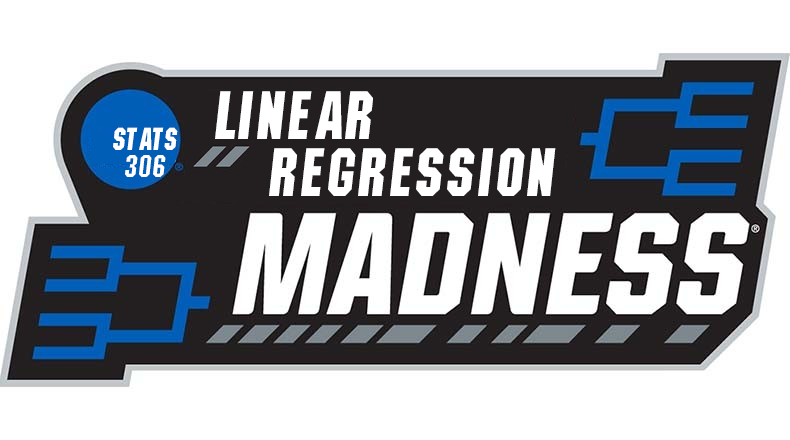

## NCAA data
The files in `data/` ([source](https://github.com/brendanlong/ncaa-predict)) represent 17 years of NCAA basketball data (players/schools/games):

In [3]:
dir("ncaa/")

 [1] "ncaa_games_2002.csv.gz" "ncaa_games_2003.csv.gz" "ncaa_games_2004.csv.gz"
 [4] "ncaa_games_2005.csv.gz" "ncaa_games_2006.csv.gz" "ncaa_games_2007.csv.gz"
 [7] "ncaa_games_2008.csv.gz" "ncaa_games_2009.csv.gz" "ncaa_games_2010.csv.gz"
[10] "ncaa_games_2011.csv.gz" "ncaa_games_2012.csv.gz" "ncaa_games_2013.csv.gz"
[13] "ncaa_games_2014.csv.gz" "ncaa_games_2015.csv.gz" "ncaa_games_2016.csv.gz"
[16] "ncaa_games_2017.csv.gz" "ncaa_games_2018.csv.gz" "ncaa_games_2019.csv.gz"
[19] "ncaa_schools.csv.gz"   

### Exercise
Import all of games from 2002-2019 and join the school information.

In [ ]:
# Solution

In [122]:
schools <- read_csv("ncaa/ncaa_schools.csv.gz")
games = str_c("ncaa/ncaa_games_", 2002:2019, ".csv.gz") %>% map_dfr(read_csv) %>% 
        mutate(game_date = mdy(game_date)) %>% 
        inner_join(schools) %>%
        mutate(is_home = location == "Home",
               home_score = ifelse(is_home, score, opponent_score),
               away_score = ifelse(is_home, opponent_score, score),
               home_team = ifelse(is_home, school_name, opponent_name),
               away_team = ifelse(is_home, opponent_name, school_name))

Parsed with column specification:
cols(
  school_id = col_double(),
  school_name = col_character()
)
Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_double(),
  opponent_score = col_double(),
  location = col_character(),
  neutral_site_location = col_character(),
  game_length = col_character(),
  attendence = col_double(),
  opponent_id = col_double(),
  year = col_double(),
  school_id = col_double()
)
Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_double(),
  opponent_score = col_double(),
  location = col_character(),
  neutral_site_location = col_character(),
  game_length = col_character(),
  attendence = col_double(),
  opponent_id = col_double(),
  year = col_double(),
  school_id = col_double()
)
Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_double(),
  oppone

Here is our data:

In [48]:
print(games)

# A tibble: 542,617 x 12
   opponent_name game_date  score opponent_score location neutral_site_lo…
   <chr>         <date>     <dbl>          <dbl> <chr>    <chr>           
 1 Sul Ross St.  2001-11-16    93             59 Home     <NA>            
 2 Texas St.     2001-11-25    89             99 Home     <NA>            
 3 Loyola Chica… 2001-11-29    66             86 Away     <NA>            
 4 Illinois      2001-12-01    56             80 Away     <NA>            
 5 Texas         2001-12-05    64             89 Away     <NA>            
 6 UTEP          2001-12-08    56             82 Away     <NA>            
 7 Lamar         2001-12-15    67             69 Home     <NA>            
 8 San Francisco 2001-12-18    80             75 Home     <NA>            
 9 Denver        2001-12-21    81             79 Home     <NA>            
10 Wayland Bapt… 2001-12-28    92             83 Home     <NA>            
# … with 542,607 more rows, and 6 more variables: game_length <chr>,
#   at

Notice that many games are represented twice:

In [124]:
filter(games, opponent_name == "Michigan", year(game_date) == 2018, school_name == "Ohio St.")
filter(games, opponent_name == "Ohio St.", year(game_date) == 2018, school_name == "Michigan")

  opponent_name game_date  score opponent_score location neutral_site_location
1 Michigan      2018-02-18 62    74             Away     NA                   
  game_length attendence opponent_id year school_id school_name is_home
1 NA          12707      418         2018 518       Ohio St.    FALSE  
  home_score away_score home_team away_team
1 74         62         Michigan  Ohio St. 

  opponent_name game_date  score opponent_score location neutral_site_location
1 Ohio St.      2018-02-18 74    62             Home     NA                   
  game_length attendence opponent_id year school_id school_name is_home
1 NA          12707      518         2018 418       Michigan    TRUE   
  home_score away_score home_team away_team
1 74         62         Michigan  Ohio St. 

## Predicting success in the NCAA
We will use regression and modeling to predict which teams are most likely to succeed in March Madness.

First we will simply rank the schools by their margins:

In [125]:
games %>% mutate(margin = score - opponent_score) %>% group_by(school_name) %>% 
          summarize(m = mean(margin), n = n()) %>% top_n(10, m) %>% 
          arrange(desc(m))

   school_name   m        n  
1  West Liberty  14.71504 565
2  Amherst       14.04915 529
3  Gonzaga       13.63252 615
4  Wooster       13.20401 549
5  Duke          13.08075 644
6  Kansas        12.57692 650
7  Findlay       12.18360 561
8  Whitworth     12.05169 503
9  Southern Ind. 11.76964 560
10 Williams      11.63813 514

The highest ranking schools are mostly small. To pick out the top-tier teams we can look at attendance:

In [126]:
top_schools <- games %>% mutate(margin = score - opponent_score) %>% group_by(school_id) %>% 
            summarize(a = sum(attendence), m = mean(margin)) %>% inner_join(schools) %>% 
            top_n(100, a) %>% arrange(desc(m))  %>% print

Joining, by = "school_id"


# A tibble: 100 x 4
   school_id        a     m school_name   
       <dbl>    <dbl> <dbl> <chr>         
 1       260  4380488 13.6  Gonzaga       
 2       193  8497348 13.1  Duke          
 3       328 10192544 12.6  Kansas        
 4       334 12465692 10.6  Kentucky      
 5       367 10617557 10.5  Louisville    
 6       457 10833829 10.2  North Carolina
 7       235  7706129 10.2  Florida       
 8       404  7424906  8.93 Memphis       
 9       416  9469203  8.73 Michigan St.  
10       796  9459703  8.55 Wisconsin     
# … with 90 more rows


To make the analysis more manageable for this lecture, we will restrict to only these top 100 teams:

In [127]:
top_filter <- top_schools %>% mutate(top = TRUE) %>% select(school_name, top)
top_games <- games %>% left_join(top_filter, by=c('school_name' = 'school_name')) %>% 
                       left_join(top_filter, by=c('opponent_name' = 'school_name')) %>% 
                       filter(top.x | top.y, location != "Neutral") %>% ungroup %>% print

# A tibble: 68,090 x 19
   opponent_name game_date  score opponent_score location neutral_site_lo…
   <chr>         <date>     <dbl>          <dbl> <chr>    <chr>           
 1 Illinois      2001-12-01    56             80 Away     <NA>            
 2 Texas         2001-12-05    64             89 Away     <NA>            
 3 UTEP          2001-12-08    56             82 Away     <NA>            
 4 San Diego St. 2002-01-08    79             82 Home     <NA>            
 5 Missouri      2001-11-14    58             86 Away     <NA>            
 6 Fresno St.    2001-12-01    52             68 Away     <NA>            
 7 UNLV          2002-01-07    54             66 Home     <NA>            
 8 New Mexico    2002-01-14    47             50 Away     <NA>            
 9 Utah          2002-01-19    57             63 Home     <NA>            
10 BYU           2002-01-21    74             64 Home     <NA>            
# … with 68,080 more rows, and 13 more variables: game_length <chr>,
#   att

## Ranking the teams: logistic regression MCMC
We will use a model called [logistic regression MCMC](https://pdfs.semanticscholar.org/bb21/8ea8e16cc43afb7f50eefc0bea4b0fd35ff1.pdf) to build rankings for the NCAA teams. The basic model is as follows:
- We imagine that there is an imaginary person whose job it is to vote on the best team. 
- The voter picks a random team as the best to begin with, and then iterates the following procedure: 
    - Given that the voter currently believes that team $A$ is the best, she picks a random game that team $A$ played versus some team $B$. 
    - With probability $p$, the voter decides that the winner of $A$ vs. $B$ is the new best team, and with probability $(1-p)$ the voter decides that the *loser* is the new best team.

Suppose team $i$ played $N_i$ games in total. Let $w_{ij},l_{ij}$ be the number of games that $i$ won/lost against team $j$. The probability that our voter goes from thinking that $i$ is the best team, to thinking that $j$ is the best team, is 

$$M_{ij} =\frac{1}{N_i}[w_{ij}(1-p) + l_{ij}(p)].$$

The probability $p$ should not necessarily be fixed. It should be high if team $A$ was "clearly better" than team $B$, whereas if $A$ just "barely beat" team $B$ then it should be close to 1/2.

In this model the probability $p$ will be a function of the *point spread* between teams $A$ and $B$. Specifically, $p(x)$ is the probability that a team that outscores its opponent by $x$ points at home is better than its opponent. This way, very small point spreads can correspond to $p \approx 1/2$ -- it's a tossup which team is better in this scenario.

## Logistic regression model
To use this model for March madness, we need a way to estimate 

$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points}).$$

That is, we want to estimate a function $p(x)$ that returns this probability. 

Recall logistic regression from Lecture 16:

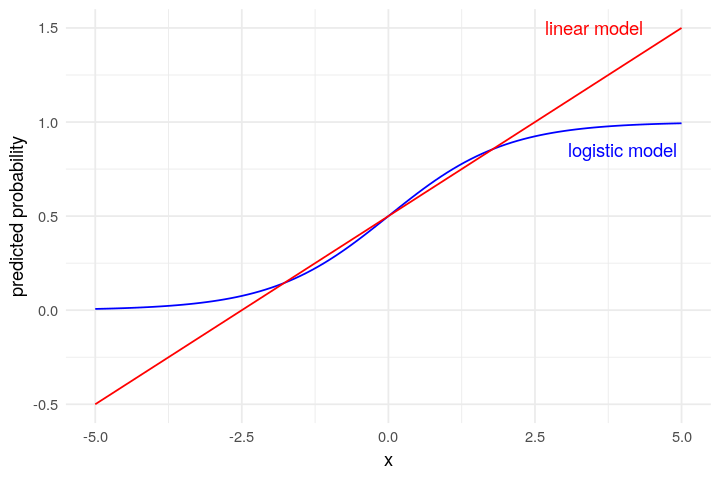

To use logistic regression to estimate this function, we'll create a dataset of pairs of games. Most conference teams play each other twice per season, once at each campus. We'll look at the outcome of one of the games and use it to predict the outcome of the second game according to the above model.

### Exercise
Construct a dataset `game_pairs` consisting of game pairs (teams which played each other twice during the season.) Each row should have two columns, `school_A` and `school_B`, and columns `beat_on_road` and `home_margin` indicating whether A beat B on the road, and what was A's margin when they played at home.

In [55]:
# Solution

In [129]:
game_pairs <- inner_join(top_games, top_games, by = c("home_team" = "away_team",
                                              "away_team" = "home_team",
                                              "year")) %>% 
             filter(game_date.x != game_date.y) %>% 
             mutate(home_margin = home_score.x - away_score.x,
                    beat_on_road = away_score.y > home_score.y) %>%
             distinct(home_team, away_team, year, home_margin, beat_on_road) %>% print

# A tibble: 13,879 x 5
   home_team  away_team      year home_margin beat_on_road
   <chr>      <chr>         <dbl>       <dbl> <lgl>       
 1 Air Force  UNLV           2002         -12 FALSE       
 2 New Mexico Air Force      2002           3 FALSE       
 3 Air Force  Utah           2002          -6 FALSE       
 4 Air Force  BYU            2002          10 FALSE       
 5 Wyoming    Air Force      2002           7 TRUE        
 6 Air Force  San Diego St.  2002          13 FALSE       
 7 Air Force  New Mexico     2002           3 FALSE       
 8 Utah       Air Force      2002           8 TRUE        
 9 BYU        Air Force      2002          16 FALSE       
10 Air Force  Wyoming        2002          -3 FALSE       
# … with 13,869 more rows


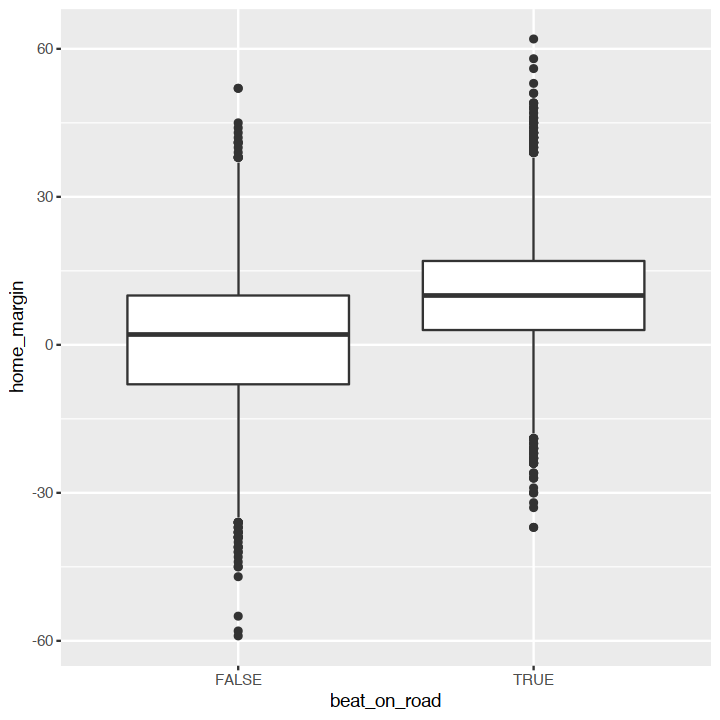

In [130]:
ggplot(game_pairs, aes(x = beat_on_road, y = home_margin)) + geom_boxplot()

Recall that we want to estimate 

$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points}).$$

But we do not observe how the teams will fare when playing on a neutral court. How should we proceed?

A team that wins by $x$ points at home would be
expected to win by $x – h$ at the neutral site, where $h$ is some estimate of the home court advantage. How do we estimate the home court advantage? Thinking back to our model, consider the value of $h$ such that 

$$\mathbb{P}(\text{Team A will beat team B on an away court}\mid \text{Team A's home margin vs. Team B was $h$ points}) = \frac{1}{2}.$$

This says that A's inherent advantage over B is exactly cancelled out by B's home court advantage. Thus, A's advantage in front of their home crowd is $2h$, and their advantage in front of a neutral crowd is $h$. 

So 
$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points}) \approx \mathbb{P}(\text{Team A will beat team B on B's court}\mid \text{Team A's home margin vs. Team B was $x + h$ points}).$$




In [131]:
model = glm(beat_on_road ~ home_margin, data = game_pairs, family = "binomial")
summary(model)


Call:
glm(formula = beat_on_road ~ home_margin, family = "binomial", 
    data = game_pairs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1145  -0.9439  -0.6693   1.1788   2.4656  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.864946   0.021286  -40.63   <2e-16 ***
home_margin  0.057451   0.001593   36.06   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 18221  on 13878  degrees of freedom
Residual deviance: 16671  on 13877  degrees of freedom
AIC: 16675

Number of Fisher Scoring iterations: 3


Let's see how well our logistic regression model fits to data:

In [132]:
predictions <- game_pairs %>% group_by(home_margin) %>% 
    summarize(p_win = mean(beat_on_road), sdp = sd(beat_on_road)) %>%
    add_predictions(model) %>% mutate(pred = plogis(pred))

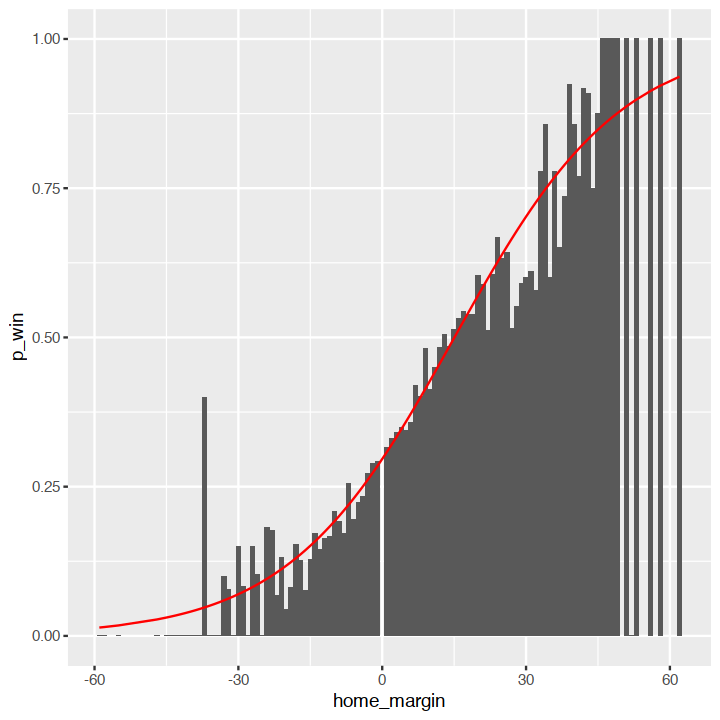

In [133]:
predictions %>% 
    ggplot(aes(x = home_margin)) + 
    geom_col(aes(y = p_win)) + 
    geom_line(aes(y = pred), color = "red")

Our logistic regression model is $$\log \left( \frac{p}{1-p} \right) = \alpha + \beta x.$$ If $p=1/2$ then the LHS is zero, and we get simply $h = -\alpha/\beta$.

In [134]:
beta = coef(model)
(h = -beta[1] / beta[2])
r_H = function(x) plogis(beta[1] + beta[2] * (x + h))

(Intercept) 
   15.05525 

Finally we construct our voter model. We'll make a matrix whose entry $M_{ij}$ equals the probability, estimated by our logistic regression model, that team $i$ is better than team $j$. Each time we cast a vote with probability $M_{ij}$ that team $i$ is better than team $j$. Our estimate of the best team is the one for whom we most frequently vote.

Let's illustrate this procedure with three teams: <span style="color: navy;">Michigan</span>, <span style="color: darkgreen">Michigan State</span>, and <span style="color: red;">Ohio State</span>. Our matrix M looks like:

$$
M = 
\begin{pmatrix}
\color{navy}{.6} & \color{darkgreen}{.3} & \color{red}{.1}  \\ 
\color{navy}{.2} & \color{darkgreen}{.4} & \color{red}{.4}  \\ 
\color{navy}{.7} & \color{darkgreen}{.1} & \color{red}{.2} 
\end{pmatrix}
$$

Row/column 1 corresponds to Michigan, row/column 2 to MSU, row/column 3 corresponds to Ohio State. If I'm in row 1, then there is a 30% chance that I vote for Michigan State to be the best, and a 10% chance that I vote for Ohio State to be the best; otherwise, I vote for Michigan to be the best.

In [9]:
library(tidyverse)
mioh <- c("UM", "MSU", "OSU")
M = matrix(c(.6, .2, .7, .3, .4, .1, .1, .4, .2), nrow=3, dimnames=list(mioh, mioh)) %>% print

     UM MSU OSU
UM  0.6 0.3 0.1
MSU 0.2 0.4 0.4
OSU 0.7 0.1 0.2


We can simulate one round of voting by multiplying this matrix with itself:

In [10]:
M %*% M
# ^^^ matrix multiplication

    UM   MSU  OSU 
UM  0.49 0.31 0.20
MSU 0.48 0.26 0.26
OSU 0.58 0.27 0.15

If we repeat this a large number of times, something interesting happens:

In [11]:
P <- M
for (i in 1:10) P <- P %*% P
P

    UM        MSU       OSU      
UM  0.5057471 0.2873563 0.2068966
MSU 0.5057471 0.2873563 0.2068966
OSU 0.5057471 0.2873563 0.2068966

The probabilities have converged. 

Technically this is a Markov chain. The vector of stationary probabilities is exactly the eigenvector of the matrix $M$ corresponding to eigenvalue 1. You can learn more about Markov chains in STATS 430.

In [12]:
evd <- eigen(t(M))
p <- evd$vectors[,1]
p <- abs(p / sum(p))
names(p) <- rownames(M)
p

       UM       MSU       OSU 
0.5057471 0.2873563 0.2068966 

Now let's write code that forms this matrix for all the teams in our data set:

In [336]:
# this takes a while
games2 <- mutate(games, is_away = !is_home,
                        home_margin = (-1)^is_away * margin, 
                        r = r_H(home_margin))
for (k in 1:nrow(games2)) {
    row = games2[k, ]
    a <- row$school_name
    b <- row$opponent_name
    r <- row$r
    if (row$location == "Home") {
        p <- 1 - r
    } else if (row$location == "Away") {
        p <- r
    } else {
        next  # skip postseason games
    }
    M[i, j] <- M[i, j] + p  # prob(j is better)
    M[j, i] <- M[j, i] + (1 - p)  # prob(i is better)
    N[i] <- N[i] + 1
    N[j] <- N[j] + 1
}

In [272]:
# Md <- M / N 
# diag(Md) <- 1 - rowSums(Md)
# nans <- apply(Md, 1, function(row) any(is.nan(row)))
# Md <- Md[!nans, !nans]
# degen = near(diag(Md), 1)
# Md = Md[!degen, !degen]
# Md <- Md / rowSums(Md)
# save(Md, file="Md.RData")

In [328]:
load("Md.Rdata")
Md[1:5, 1:5]

                   A&M-Corpus Christi Abilene Christian Adams St. Adelphi  
A&M-Corpus Christi 0.49143065         0.00373781        0.0000000 0.0000000
Abilene Christian  0.01214073         0.42810189        0.0000000 0.0000000
Adams St.          0.00000000         0.00000000        0.4898049 0.0000000
Adelphi            0.00000000         0.00000000        0.0000000 0.5544908
Adrian             0.00000000         0.00000000        0.0000000 0.0000000
                   Adrian  
A&M-Corpus Christi 0.000000
Abilene Christian  0.000000
Adams St.          0.000000
Adelphi            0.000000
Adrian             0.472928

Now we have a large matrix $M$ that implements the "voter model" described a few slides ago: the probability that the voter goes from thinking team $i$ is the best to the thinking team $j$ is the best is given by $M_{ij}$. Let's check these probabilities in a few cases:

In [337]:
# strong team vs strong team
Md["Duke","North Carolina"]
# strong team vs weak team
Md["Duke","Ohio St."]

[1] 0.03647588

[1] 0.002890715

Suppose we let the voter vote for an infinite number of rounds, and then take the average amount of time that she believes each school is "the best". For each school $i$, we get a number $p_i \in [0,1]$ that measures the fraction of time that the voter thought that school $i$ was "the best". The $p_i$ are like rankings for each school; larger is better.

In [294]:
rankings <- tibble(school_name = names(p), p = p)
rankings %>% arrange(desc(p)) %>% print

# A tibble: 1,124 x 2
   school_name          p
   <chr>            <dbl>
 1 Kansas         0.00494
 2 Duke           0.00482
 3 North Carolina 0.00433
 4 Louisville     0.00425
 5 Kentucky       0.00417
 6 Wisconsin      0.00415
 7 Florida        0.00401
 8 Arizona        0.00390
 9 Ohio St.       0.00389
10 Pittsburgh     0.00385
# ... with 1,114 more rows
